# Ray Tune Optimization Experiment III
## with Class API Baseline

## 0. Import / Setup

In [1]:
# Import Packages
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import warnings
plt.style.use('seaborn')
warnings.filterwarnings(action='ignore')

# Ray Tune
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.suggest.basic_variant import BasicVariantGenerator
from ray.tune.suggest.bayesopt import BayesOptSearch
from ray.tune.suggest.hebo import HEBOSearch

In [2]:
# Initialization
import ray
ray.shutdown()
ray.init(num_cpus=8, num_gpus=1)

2021-07-20 18:40:51,709	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.219.106',
 'raylet_ip_address': '192.168.219.106',
 'redis_address': '192.168.219.106:6379',
 'object_store_address': 'tcp://127.0.0.1:61990',
 'raylet_socket_name': 'tcp://127.0.0.1:63370',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\jinyo\\AppData\\Local\\Temp\\ray\\session_2021-07-20_18-40-48_152463_16240',
 'metrics_export_port': 63467,
 'node_id': 'ab1dd5ba7ceddfba2cbfbfe7a8691b9b2aeb0d4e6415a51dfa46e204'}

## 1. Function / Class Definition

### Arbitrary Loss Function

In [3]:
# Loss Function Definition

def hyperparam_field(x, y):
    # Himmelblau Function
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def param_field(x):
    # Quartic Function
    return (x**2-4)**2 + 0.25*(x-2)**2

def param_field_diff(x):
    # return d(param_field)/dx
    return 4*(x**3 - 3.875*x - 0.25)

def loss(alpha, beta, delta):
    return param_field(delta) + 0.005*hyperparam_field(alpha, beta)

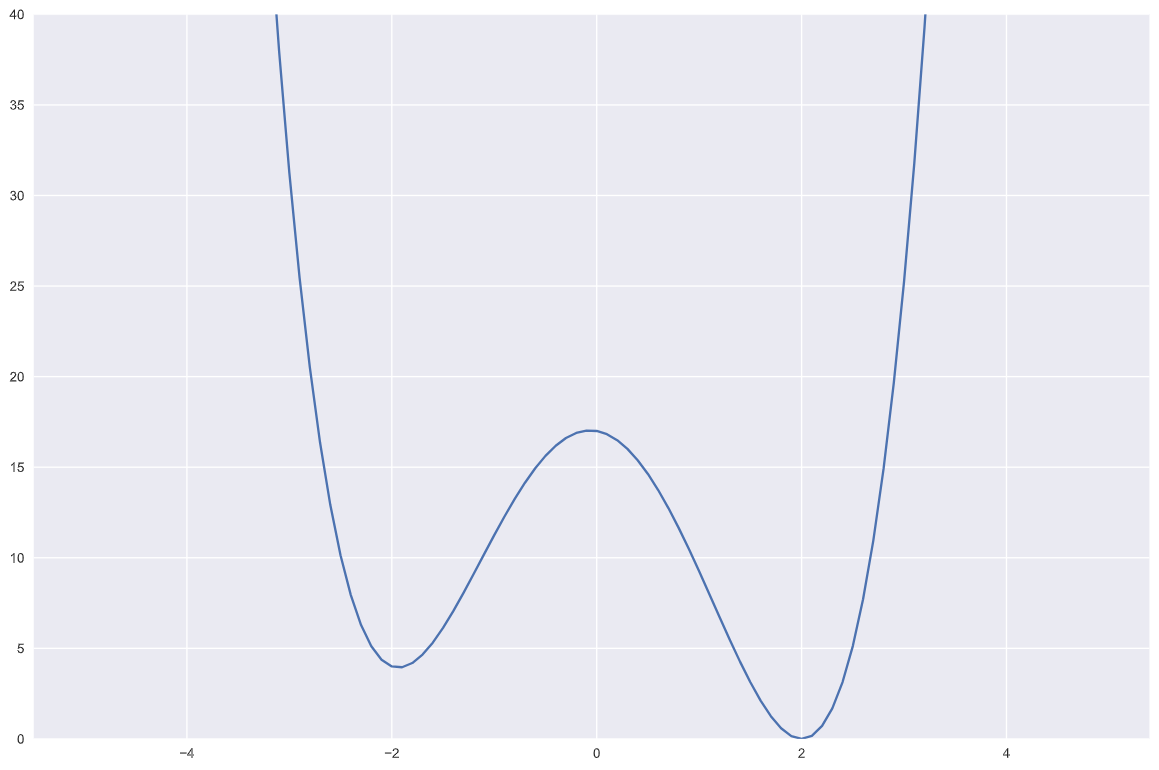

In [4]:
# Visualization of Parameter Field

Image('./fig/paramfield.png')

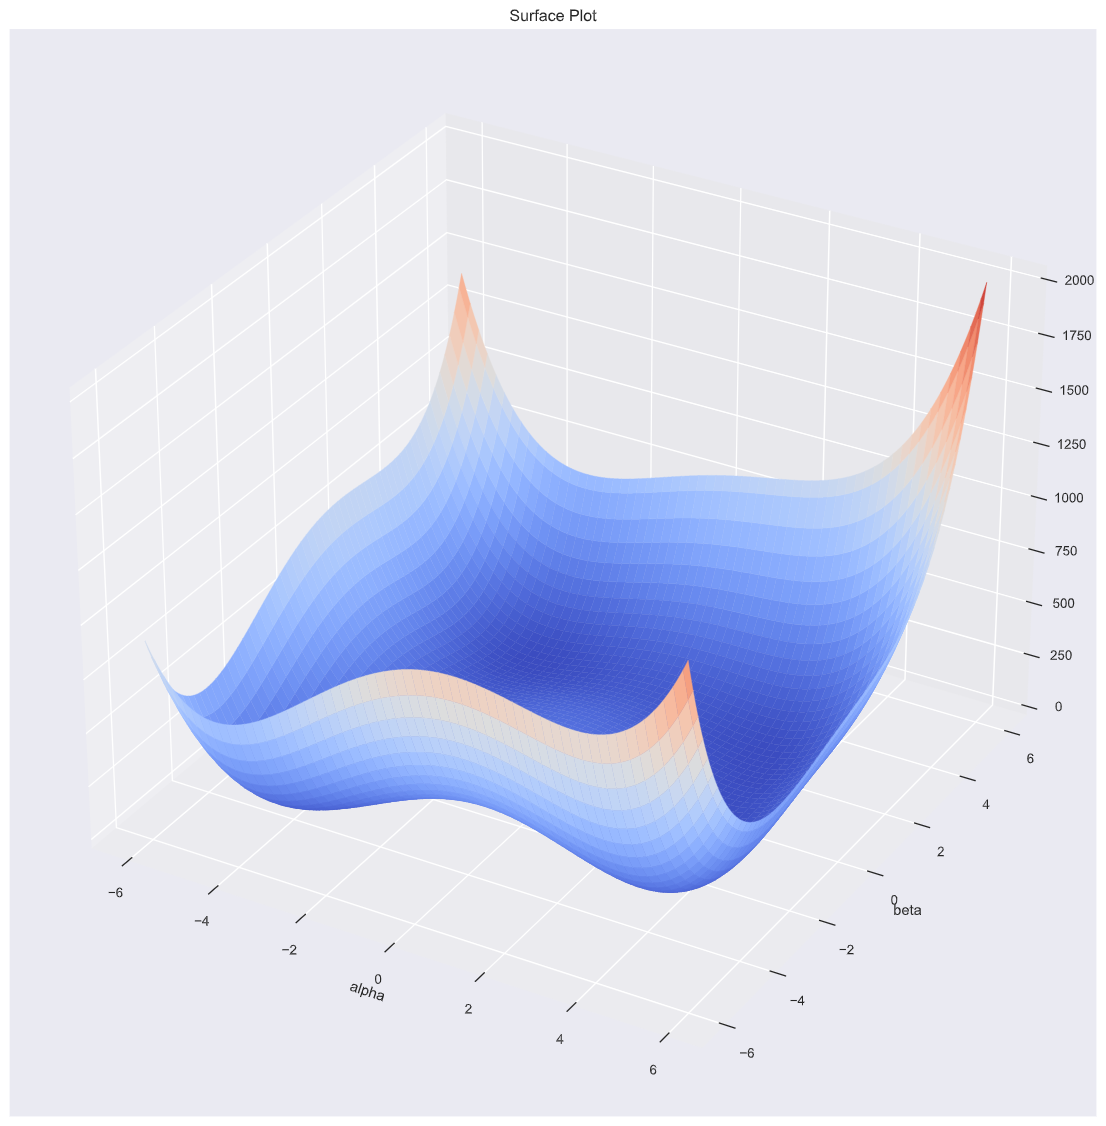

In [5]:
# Visualization of Hyperparameter Field 1

Image('./fig/hyperparam_field_surface_plot.png')

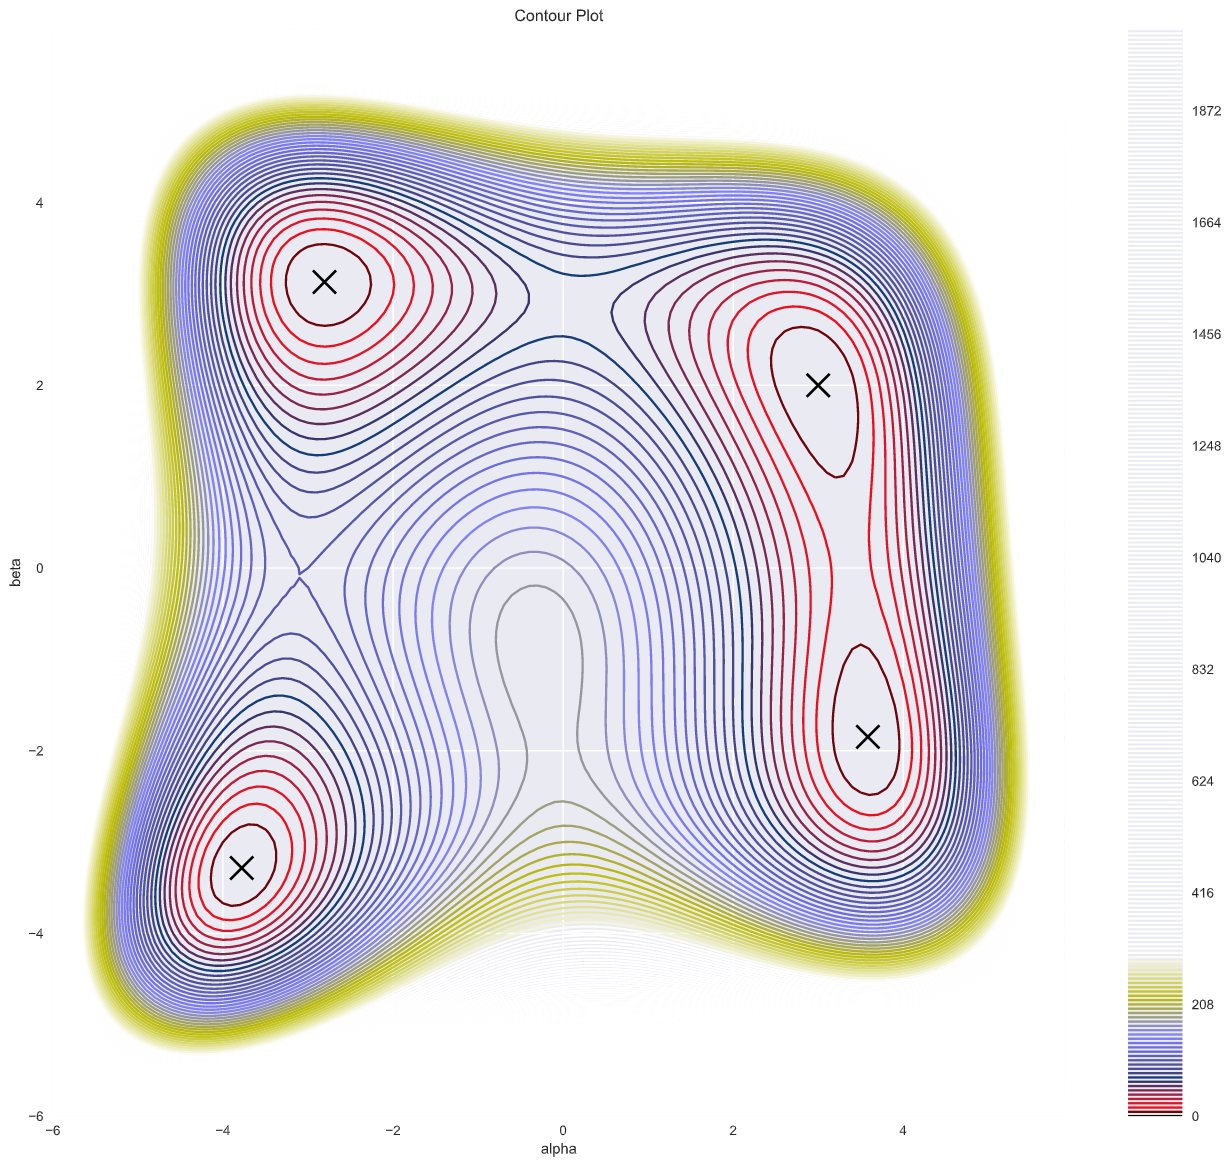

In [6]:
# Visualization of Hyperparameter Field 2

Image('./fig/hyperparam_field_contour_plot.png')

### Trainable Class
#### * This class should be modified in every projects.

In [7]:
class Trainable(tune.Trainable):
    '''
        Every Trainable class should have 3 functions:
            setup : invoked once training starts
            step : invoked multiple times (=epoch)
            cleanup(optional) : invoked when training is finished
        For Checkpoint:
            save_checkpoint : save model
            load_checkpoint : load model
    '''

    def setup(self, config):

        # Hyperparameters (config)
        self.alpha = config['alpha']
        self.beta = config['beta']
        self.lr = config['lr']
        try: self.report_per_step = config['report_per_step']
        except: self.report_per_step = 0

        # Parameters
        self.delta = 10*np.random.rand(1)[0]-5 # range: (-5,5)

        # for Early Stopping
        self.step_count = 0
        self.min_val_delta = self.delta
        self.min_val_loss = np.Inf
        self.min_val_step = 0
    

    def step(self):
        # Training
        train_loss = loss(self.alpha, self.beta, self.delta)
        self.delta -= self.lr*param_field_diff(self.delta)

        # Validation
        # (delta -> delta-0.1 for overfitting situation)
        val_loss = loss(self.alpha, self.beta, self.delta - 0.1)

        # Step Count
        self.step_count += 1

        # Early Stopping Algorithm
        if self.min_val_loss > val_loss:
            self.min_val_delta = self.delta
            self.min_val_loss = val_loss
            self.min_val_step = self.step_count
        
        if self.report_per_step:
            if (self.step_count+1)%self.report_per_step==0:
                print("[Step {:03d}] Train Loss: {:.2f}, Validation Loss: {:.2f}".format(self.step_count+1, train_loss, val_loss))
        
        #### Return ####        
        return {"train_loss": train_loss,
                "val_loss": val_loss,
                "min_val_loss": self.min_val_loss,
                "min_val_step": self.min_val_step}
        

    def cleanup(self):
        if self.report_per_step:
            print("Training Finished")
    
    
    def save_checkpoint(self, temp_check_dir):
        # Numpy Implementation
        # (should be modified in PyTorch Implementation)
        CHECK_PATH = os.path.join(temp_check_dir, 'checkpoint')
        np.save(CHECK_PATH, np.array([self.min_val_delta]))
        return temp_check_dir
    

    def load_checkpoint(self, temp_check_dir):
        # Numpy Implementation
        # (should be modified in PyTorch Implementation)
        CHECK_PATH = os.path.join(temp_check_dir, 'checkpoint.npy')
        self.delta = np.load(CHECK_PATH)
        return temp_check_dir

### Stopper Class

In [8]:
from collections import defaultdict

class EarlyStopper(tune.Stopper):
    '''
        Every Stopper class should have 3 functions:
            __init__(self)
            __call__(self, trial_id, result)
                : return True if the trial should be terminated
            stop_all(self)
                : return True if the experiment should be terminated
    '''

    def __init__(self, metric, mode, patience=10, delta=0):
        # Goal : To minimize "metric"
        self._metric = metric
        self._mode = mode
        self._patience = patience
        self._delta = delta
        self._counter = defaultdict(int)
        self._min_metric = defaultdict(lambda: np.Inf)
    
    def __call__(self, trial_id, result):
        metric_result = result.get(self._metric)
        if self._mode == 'max':
            metric_result = -metric_result
        if self._min_metric[trial_id] > metric_result + self._delta:
            self._counter[trial_id] = 0
            self._min_metric[trial_id] = metric_result
        else:
            self._counter[trial_id] += 1   
        return self._counter[trial_id] >= self._patience
    
    def stop_all(self):
        return False

### Optimization Class

In [9]:
class Optimization:
    def __init__(self, trainable):
        '''
            Main args
                trainable : Trainable Class (with Tune API)
            Main parameters
                output : call by optim.output[run_name]
        '''
        
        self.trainable = trainable
        self.output = dict()
    
    def train(self,
              config,
              num_samples=1,
              max_step=1,
              early_stop=True,
              patience=10,
              delta=0,
              metric='min_val_loss',
              mode='min',
              default_metric=['train_loss', 'val_loss',
                              'min_val_loss', 'min_val_step'],
              add_metric=[],
              run_name=None,
              checkpoint_freq=0,
              checkpoint_at_end=True,
              verbose=0,
              report_per_step=1,
              resources_per_trial={'cpu':2},
              local_dir='./ray_results',
              trial_name_creator=lambda trial: f'Trial_{trial.trial_id}',
              trial_dirname_creator=lambda trial: f'Trial_{trial.trial_id}'):
        '''
            Main args
                config : Hyperparameter Configuration
                # num_samples : number of samples (exact: num_samples * grid)
                              *** "train" : num_samples = 1 in general
                max_step : maximum number of steps
                early_stop : Early Stopping
                patience : if early_stop, patience step number
                delta : if early_stop, minimum improvement size
                add_metric : e.g. ['acc', 'val_acc']
                run_name : name of output / folder
                report_per_step : train verbose
        '''

        if report_per_step:
            config['report_per_step'] = report_per_step

        reporter = JupyterNotebookReporter(
            overwrite=True,
            metric_columns=(default_metric+add_metric+['training_iteration'])
        )

        if early_stop:
            # Use Custom EarlyStopper
            stop = tune.stopper.CombinedStopper(
                tune.stopper.MaximumIterationStopper(max_iter=max_step),
                EarlyStopper(metric=metric, mode=mode, patience=patience, delta=delta)
            )
        else:
            stop = tune.stopper.MaximumIterationStopper(max_iter=max_step)
            metric = 'val_loss'

        # Training
        self.output[run_name] = tune.run(
            self.trainable,
            config=config,
            num_samples=num_samples,
            progress_reporter=reporter,
            stop=stop,
            metric=metric,
            mode=mode,
            name=run_name,
            checkpoint_freq=checkpoint_freq,
            checkpoint_at_end=checkpoint_at_end,
            verbose=verbose,
            resources_per_trial=resources_per_trial,
            local_dir=local_dir,
            trial_name_creator=trial_name_creator,
            trial_dirname_creator=trial_dirname_creator
        )

    def tune(self,
             config,
             num_samples=1,
             max_step=1,
             early_stop=True,
             patience=10,
             delta=0,
             scheduler=None,
             search_alg=None,
             metric='min_val_loss',
             mode='min',
             default_metric=['train_loss', 'val_loss',
                             'min_val_loss', 'min_val_step'],
             add_metric=[],
             run_name=None,
             checkpoint_freq=0,
             checkpoint_at_end=True,
             verbose=2,
             resources_per_trial={'cpu':2},
             local_dir='./ray_results',
             trial_name_creator=lambda trial: f'Trial_{trial.trial_id}',
             trial_dirname_creator=lambda trial: f'Trial_{trial.trial_id}'
             ):
        '''
            Main args
                config : Hyperparameter Configuration
                num_samples : number of samples (exact: num_samples * grid)
                max_step : maximum number of steps
                early_stop : Early Stopping
                patience : if early_stop, patience step number
                delta : if early_stop, minimum improvement size
                run_name : name of output / folder
                scheduler : scheduler (ASHA, HyperBand, ...)
                search_alg : search algorithm (Bayesian, Ax, HEBO, ...)
        '''

        reporter = JupyterNotebookReporter(
            overwrite=True,
            metric_columns=(default_metric+add_metric+['training_iteration'])
        )

        if early_stop:
            # Use Custom EarlyStopper
            stop = tune.stopper.CombinedStopper(
                tune.stopper.MaximumIterationStopper(max_iter=max_step),
                EarlyStopper(metric=metric, mode=mode, patience=patience, delta=delta)
            )
        else:
            stop = tune.stopper.MaximumIterationStopper(max_iter=max_step)
            metric = 'val_loss'

        self.output[run_name] = tune.run(
            self.trainable,
            config=config,
            num_samples=num_samples,
            scheduler=scheduler,
            search_alg=search_alg,
            progress_reporter=reporter,
            stop=stop,
            metric=metric,
            mode=mode,
            name=run_name,
            checkpoint_freq=checkpoint_freq,
            checkpoint_at_end=checkpoint_at_end,
            verbose=verbose,
            resources_per_trial=resources_per_trial,
            local_dir=local_dir,
            trial_name_creator=trial_name_creator,
            trial_dirname_creator=trial_dirname_creator
        )

### Visualization Class

In [10]:
class Visualization:
    # Do something with tune.ExperimentAnalysis
    def __init__(self,
                 output,
                 metric='min_val_loss',
                 mode='min',
                 default_metric=['train_loss', 'val_loss',
                                  'min_val_loss', 'min_val_step'],
                 add_metric=[]):

        self.output = output
        self.metric = metric
        self.mode = mode
        self.all_df = output.dataframe().sort_values(
                      by=[metric], axis=0, ascending=(mode=='min'))
        self.all_df_idx = self.all_df.index
        self.config = self.all_df['trial_id']
        self.config_idx = []
        
        for col in self.all_df.columns:
            if 'config' in col:
                self.config_idx.append(col[len('config')+1:])
                self.config = pd.concat([self.config, self.all_df.loc[:,col]], axis=1)
        self.config.columns = ['trial_id'] + self.config_idx

        self.dataframe = pd.concat([self.config, self.all_df.loc[:,default_metric+add_metric]], axis=1)
        
    
    def print_dataframe(self, head=None):
        if head: return self.dataframe[:head]
        else: return self.dataframe
    
    
    def learning_curve(self,
                       grid=(1,1),
                       figsize=(30,30),
                       fontsize=30,
                       earlystop=True,
                       show_title=True,
                       watch=['train_loss', 'val_loss'],
                       names=['Train Loss', 'Validation Loss'],
                       without_config=['report_per_step']):
        
        fig = plt.figure(figsize=figsize)
        
        for i in range(grid[0]*grid[1]):
            temp_df = self.output.trial_dataframes[self.all_df.loc[self.all_df_idx[i],'logdir']]
            ax = fig.add_subplot(grid[0], grid[1], i+1)
            for idx, value in enumerate(watch):
                ax.plot(np.arange(1, len(temp_df[value])+1), temp_df[value], label=names[idx])
            if earlystop:
                ax.axvline(self.all_df.loc[self.all_df_idx[i], 'min_val_step'],
                           linestyle='--', color='black', label='Early Stopping')
            ax.grid(True)
            ax.legend(fontsize=fontsize*0.8)
            if show_title:
                temp_title = ''
                for idx in self.config_idx:
                    if idx not in without_config:
                        temp_title += '{}:{:.2g},'.format(idx,self.config.loc[self.all_df_idx[i],idx])
                temp_title = temp_title[:-1]
                ax.set_title(temp_title, fontsize=fontsize)
            ax.set_xlabel('Steps', fontsize=fontsize*0.8)
            ax.set_ylabel('Loss', fontsize=fontsize*0.8)
        
        plt.show()
    
    
    ########## viewtype min max mean implementation needed ##########
    def scatter_plot(self,
                     config,
                     num_scatter=None,
                     logscale=[False, False],
                     viewtype='min',
                     best_highlight=False,
                     figsize=(35,30),
                     fontsize=30,
                     size=1e2,
                     highlight_size=40,
                     vmax=None,
                     vmin=None,
                     cmap=plt.cm.coolwarm_r,
                     bar_label=None):
        '''
            Args
                config : Two hyperparamters list (e.g.) ['alpha', 'beta']
                num_scatter : number of hyperparameter sets to draw
                logscale : True if log_scale (e.g.) learning rate
                viewtype : 'min', 'max' or 'mean'
                best_highlight : highlight best hyperparameter set
                bar_label : colorbar label (e.g.) 'Validation Loss'
        '''

        list_df = getattr(self.dataframe.groupby(config, as_index=False), self.mode)().sort_values(by=[self.metric])

        fig = plt.figure(figsize=figsize)
        
        config_list = [list_df.loc[:,config[0]], list_df.loc[:,config[1]]]
        config_label = config
        
        for idx in range(2):
            if logscale[idx]:
                config_list[idx] = np.log10(config_list[idx])
                config_label[idx] = 'log(' + config_label[idx] + ')'
                
        clrs = plt.scatter(config_list[0][:num_scatter],
                           config_list[1][:num_scatter],
                           s=size,
                           vmax=vmax, vmin=vmin,
                           c=list_df[self.metric][:num_scatter],
                           cmap=cmap,
                           edgecolors='black', linewidths=2)
        
        if best_highlight:
            plt.plot(config_list[0][0],
                     config_list[1][0],
                     ms=highlight_size,
                     c='black',
                     marker='X')
            
        fig.colorbar(clrs, label=bar_label if bar_label else self.metric)
        plt.xlabel(config_label[0], fontsize=fontsize*0.8)
        plt.ylabel(config_label[1], fontsize=fontsize*0.8)
        
        plt.show()
        
##### scatter plot / grid plot implementation #####
# or, just separate grid search visualization #

## 2. Training

In [11]:
optim = Optimization(Trainable)

In [12]:
optim.train(
    config={
        'alpha': 0,
        'beta' : 0,
        'lr'   : 5e-3
    },
    max_step=50,
    run_name='train',
    report_per_step=5,
    resources_per_trial={'cpu':2, 'gpu':0.25}
)

2021-07-20 18:41:10,943	ERROR syncer.py:72 -- Log sync requires rsync to be installed.
(pid=17652) [Step 005] Train Loss: 0.90, Validation Loss: 0.89
(pid=17652) [Step 010] Train Loss: 0.86, Validation Loss: 0.95
(pid=17652) Training Finished
(pid=17652) Windows fatal exception: access violation
(pid=17652) 


In [13]:
vis = Visualization(optim.output['train'])

In [14]:
vis.dataframe

,trial_id,alpha,beta,lr,report_per_step,train_loss,val_loss,min_val_loss,min_val_step
0,9d6bb_00000,0,0,0.005,5,1.022349,0.854692,0.854692,1


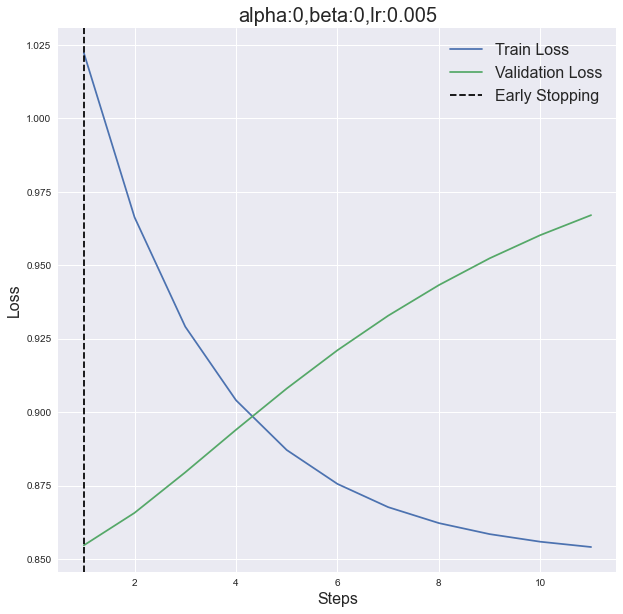

In [15]:
vis.learning_curve(figsize=(10,10), fontsize=20)

## 3. Grid Search

In [22]:
optim.tune(
    config={
        'alpha': tune.grid_search([-4, -2, 0, 2, 4]),
        'beta' : tune.grid_search([-4, -2, 0, 2, 4]),
        'lr'   : tune.grid_search([1e-3, 1e-2])
    },
    num_samples=4,
    max_step=50,
    run_name='tune_example',
    resources_per_trial={'cpu':2, 'gpu':0.25}
)

(pid=4116) Windows fatal exception: access violation
(pid=4116) 


Trial name,status,loc,alpha,beta,lr,train_loss,val_loss,min_val_loss,min_val_step,training_iteration
Trial_89531_00000,TERMINATED,,-4,-4,0.001,14.2448,15.011,15.011,50,50
Trial_89531_00001,TERMINATED,,-2,-4,0.001,5.44287,6.2601,6.2601,50,50
Trial_89531_00002,TERMINATED,,0,-4,0.001,10.6611,11.7421,11.7421,50,50
Trial_89531_00003,TERMINATED,,2,-4,0.001,1.21363,1.41124,1.41124,50,50
Trial_89531_00004,TERMINATED,,4,-4,0.001,1.03627,0.850009,0.850009,50,50
Trial_89531_00005,TERMINATED,,-4,-2,0.001,0.670975,0.319832,0.319832,50,50
Trial_89531_00006,TERMINATED,,-2,-2,0.001,4.80035,5.42732,5.42732,50,50
Trial_89531_00007,TERMINATED,,0,-2,0.001,1.45548,0.977466,0.977466,50,50
Trial_89531_00008,TERMINATED,,2,-2,0.001,0.509194,0.876988,0.876988,50,50
Trial_89531_00009,TERMINATED,,4,-2,0.001,10.7979,9.61239,9.61239,50,50


2021-07-20 18:49:38,292	INFO tune.py:549 -- Total run time: 112.19 seconds (111.99 seconds for the tuning loop).


In [23]:
result=optim.output['tune_example']

In [24]:
vis = Visualization(result)

In [25]:
vis.print_dataframe(20)

,trial_id,alpha,beta,lr,train_loss,val_loss,min_val_loss,min_val_step
109,89531_00109,4,-2,0.001,0.229967,0.050015,0.050015,47
59,89531_00059,4,-2,0.001,0.228229,0.050033,0.050033,44
184,89531_00184,4,-2,0.010,0.541319,0.050558,0.050558,3
93,89531_00093,2,2,0.010,0.442118,0.133100,0.133100,4
68,89531_00068,2,2,0.001,0.584287,0.180435,0.180435,50
84,89531_00084,4,-2,0.010,0.050000,0.204600,0.204600,50
41,89531_00041,-2,2,0.010,0.593281,0.251624,0.251624,4
194,89531_00194,4,2,0.010,0.582055,0.252092,0.252092,4
141,89531_00141,-2,2,0.010,0.571535,0.252595,0.252595,4
69,89531_00069,4,2,0.001,0.558474,0.263504,0.263504,50


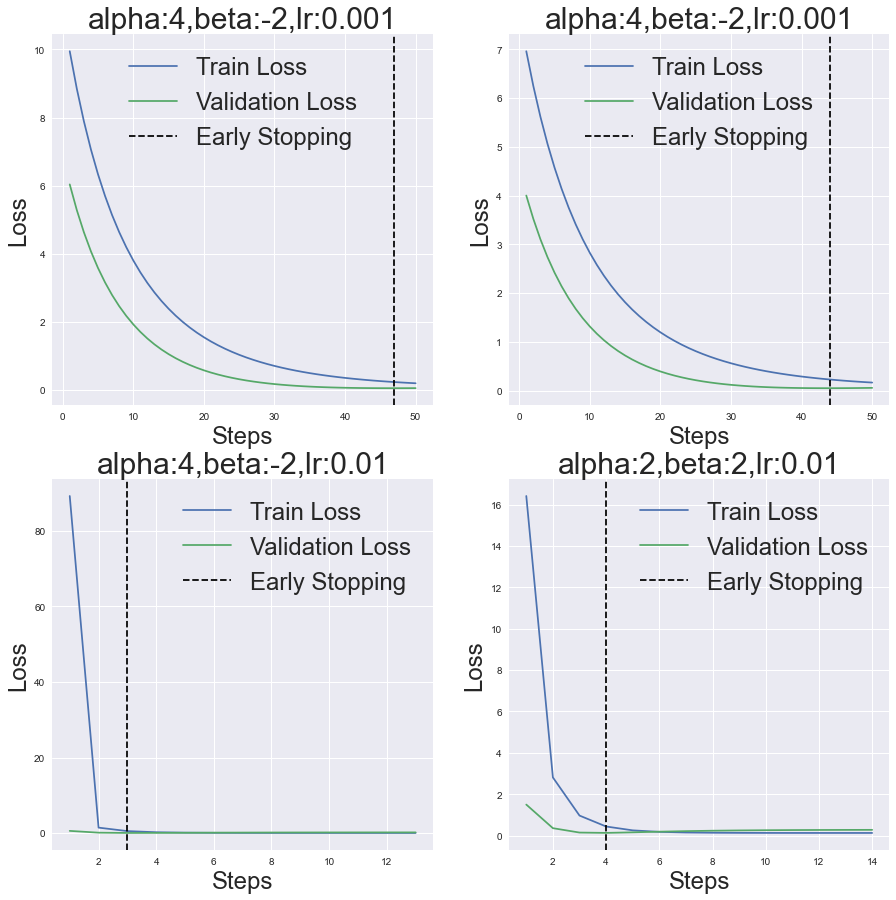

In [26]:
vis.learning_curve((2,2), figsize=(15,15))

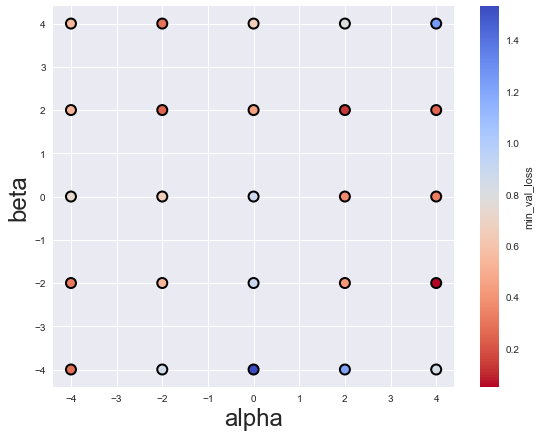

In [27]:
vis.scatter_plot(['alpha','beta'], viewtype='mean', best_highlight=False, figsize=(9,7))

## 4. Random Search

In [28]:
optim.tune(
    config={
        'alpha': tune.uniform(-5, 5),
        'beta' : tune.uniform(-5, 5),
        'lr'   : tune.loguniform(3e-4, 3e-2)
    },
    num_samples=200,
    max_step=50,
    run_name='tune_example_2',
    resources_per_trial={'cpu':2, 'gpu':0.25}
)

(pid=6992) Windows fatal exception: access violation
(pid=6992) 


Trial name,status,loc,alpha,beta,lr,train_loss,val_loss,min_val_loss,min_val_step,training_iteration
Trial_cd8be_00000,TERMINATED,,-2.83697,3.34151,0.0132875,0.00958733,0.164187,0.164187,50,50
Trial_cd8be_00001,TERMINATED,,3.95693,-1.16264,0.0055762,4.01184,4.16714,4.16714,50,50
Trial_cd8be_00002,TERMINATED,,3.34731,3.91019,0.00217981,4.69872,4.87118,4.87118,50,50
Trial_cd8be_00003,TERMINATED,,-4.8916,-4.66828,0.00676514,4.76774,4.92285,4.92285,50,50
Trial_cd8be_00004,TERMINATED,,1.65909,0.731527,0.00224741,4.44966,4.33771,4.33451,47,50
Trial_cd8be_00005,TERMINATED,,4.98142,-2.41878,0.000612822,9.82006,8.69786,8.69786,50,50
Trial_cd8be_00006,TERMINATED,,3.47004,2.49044,0.00387512,0.104356,0.308978,0.308978,50,50
Trial_cd8be_00007,TERMINATED,,-2.45839,-4.80171,0.00462475,1.40767,1.50666,1.40095,12,22
Trial_cd8be_00008,TERMINATED,,3.71797,-2.06429,0.024061,3.94415,4.09924,3.94417,2,12
Trial_cd8be_00009,TERMINATED,,-3.13434,-0.402591,0.0162429,4.44617,4.60062,4.44852,7,17


2021-07-20 18:51:32,377	INFO tune.py:549 -- Total run time: 111.82 seconds (111.61 seconds for the tuning loop).


In [29]:
result=optim.output['tune_example_2']

In [30]:
vis = Visualization(result)

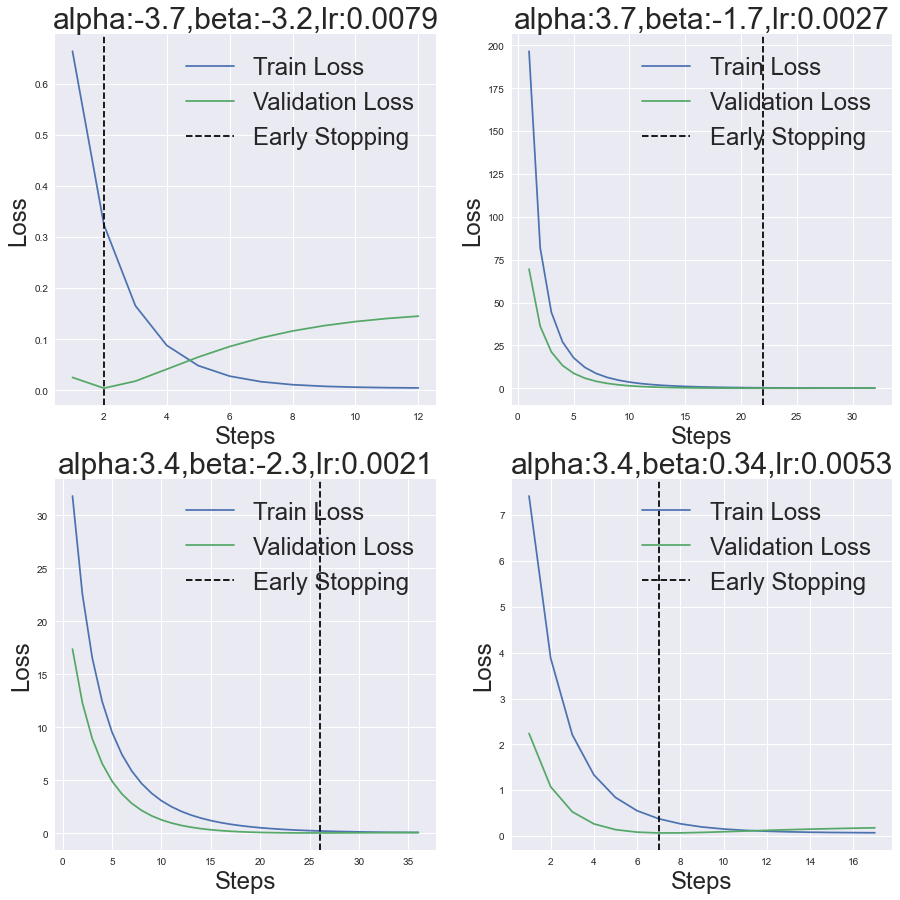

In [31]:
vis.learning_curve((2,2), figsize=(15,15))

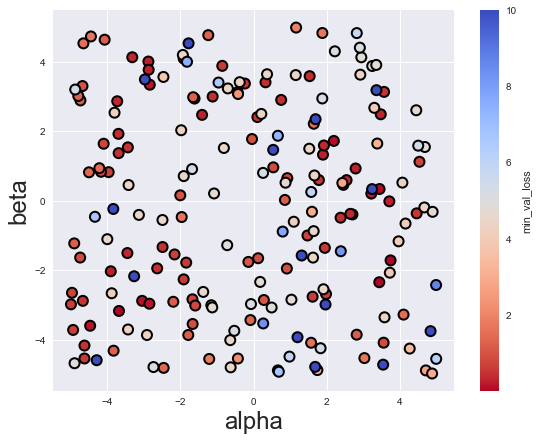

In [34]:
vis.scatter_plot(['alpha','beta'], viewtype='mean', best_highlight=False, vmax=10, figsize=(9,7))